|**Name**| **ID #** | **Email** | **When Midterm**|
| :--     |  :--      |  :--    | :--             |          
|Xuan Xu |   111675940 | xuaxu@cs.stonybrook.edu        | 10/9                |             
|Hae-Na Lee| 111207004 | haenalee@cs.stonybrook.edu | 10/13, 10/23 |            
|Caitao Zhan| 111634527| caitao.zhan@stonybrook.edu | 10/16  |




Table of  | Content
:---  |:---
**1** |**Task 1: Scoring Function to Rank Houses**
1.1   |Scoring Function
1.2   |Distribution of Desirability Scores
1.3   |Score Analysis
1.3.1 |The Most Desirable Houses: Beverly Hills
1.3.2 |The Least Desirable Houses
**2** |**Task 2: Design Pairwise Distance Function**
2.1   |Four Aspects of a Distance Function
2.2   |Baseline Distance Function
2.2.1 |Design
2.2.2 |Example
2.3   |Advanced Distance Function
2.3.1 |Design
2.3.2 |Experiment
2.4   |Discussion
**3** |**Task 3: Clustering**
3.1   |KMeans + Euclidean (pairwise_distance_baseline)
3.2   |DBSCAN + Manhanttan (pairwise_distance_advance)
3.2.1 |Data Cleaning
3.2.2 |Do the Clustering and Visualization
3.3   |Discussion
**4** |**Task 4: Adding External Data Set**
4.1   |External Data
4.1.1 |Import the Data
4.1.2 |Choose Features
4.2   |Prediction
4.3   |Discussion
**5** |**Task 5: Prediction Model**
5.1   |Modified Prediction Model
5.2   |Do the Prediction
5.3   |Discussion
**6** |**Task 6: Permutation Tests**
6.1   |Preparation for test
6.2   |120 Tests
6.3   |Discussion
**7** |**Task 7: Submit Final Result before Deadline**


At the very beginning, let's import the packages all at once.

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime, time
import copy
import random

from sklearn import preprocessing
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from sklearn.metrics.pairwise import manhattan_distances as man_dis
from sklearn.metrics.pairwise import euclidean_distances as euc_dis

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

Separately maintain both the raw data and its cleaned version.

In [ ]:
df_house16 = pd.read_csv('../data/properties_2016.csv')
df_train16 = pd.read_csv('../data/train_2016_v2.csv')

df_house17 = pd.read_csv('../data/properties_2017.csv')
df_train17 = pd.read_csv('../data/train_2017.csv')

# 1 Task 1: Scoring Function to Rank Houses

## 1.1 Scoring Function

A scoring function is designed to rank houses by desirability, which reflects cost or value.
We selected the housing variables considered to be effective on the housing value. The real-estate site ([1]) emphasized that property location is important and also mentioned that the factors such as physical state, neighborhood and layout affect property price. Therefore, the following variables are chosen to be used for the scoring function:

|  | Variable |
|:--|:--|
|1| *bedroomcnt* |
|2| *buildingqualitytypeid* |
|3| *calculatedbathnbr* |
|4| *calculatedfinishedsquarefeet* |
|5| *lotsizesquarefeet* |
|6| *yearbuilt* |

The scoring function is a linear combination of normalized variable values. The vital variables such as *buildingqualitytypeid* and *calculatedfinishedsquarefeet* are given higher weights than those of other variables.

Variables relevant to housing location (e.g. *latitude*, *longitude*) are not used to build the scoring function because the values of variables are not proper to be used in a linear combination, i.e. the higher value of latitude may not mean the higher desirability. Instead they are utilized to verify how well the scoring function works.

`[1]`: 10 Timeless Factors That Affect Property Price, http://www.propertylogy.com/knowledge/10-timeless-factors-that-affect-property-price/

In [3]:
# Read the property data
property_2017 = df_house17

**1)** Extract the features to analyze

In [4]:
feature_list = ['parcelid','bedroomcnt','buildingqualitytypeid',
                'calculatedbathnbr','calculatedfinishedsquarefeet',
                'lotsizesquarefeet','yearbuilt','structuretaxvaluedollarcnt',
                'latitude','longitude','regionidcity','regionidzip']

feature_2017 = property_2017[feature_list]

**2)** Fill in missing feature data with mean values

In [5]:
model_dataset_filled_2017 = feature_2017.fillna(feature_2017.mean())

**3)** Preprocessing Step

In [6]:
#model_dataset_norm = model_dataset
model_dataset_norm = model_dataset_filled_2017

# Normalize the features with skewed distributions
model_dataset_norm.calculatedbathnbr = np.log(model_dataset_norm.calculatedbathnbr)
model_dataset_norm.calculatedfinishedsquarefeet = np.log(model_dataset_norm.calculatedfinishedsquarefeet)
model_dataset_norm.lotsizesquarefeet = np.log(model_dataset_norm.lotsizesquarefeet)
#model_dataset_norm.roomcnt = np.log(model_dataset_norm.roomcnt)
model_dataset_norm.structuretaxvaluedollarcnt = np.log(model_dataset_norm.structuretaxvaluedollarcnt)

In [7]:
# Normalize all features

model_dataset_norm.loc[:,'bedroomcnt':'structuretaxvaluedollarcnt'] = \
 preprocessing.scale(model_dataset_norm.loc[:,'bedroomcnt':'structuretaxvaluedollarcnt'])

**4)** The scoring function

In [8]:
feature_list = ['parcelid','bedroomcnt','buildingqualitytypeid',
                'calculatedbathnbr','calculatedfinishedsquarefeet',
                'lotsizesquarefeet','yearbuilt',
                'structuretaxvaluedollarcnt','latitude','longitude','regionidcity','regionidzip']
scoring_dataset = model_dataset_norm[feature_list]

desirability_score = pd.DataFrame(scoring_dataset.bedroomcnt*0.8
 - scoring_dataset.buildingqualitytypeid
 + scoring_dataset.calculatedbathnbr*0.8
 + scoring_dataset.calculatedfinishedsquarefeet
 + scoring_dataset.lotsizesquarefeet*0.8
 + scoring_dataset.yearbuilt, columns=['score'])

# simple linear combination
# structuretaxvaluedollarcnt
# most desirables: 3.921996353698721
# lease desirables: -0.4135856986788523

**5)** Append the desirability score to the dataset

In [9]:
scoring_result = pd.concat([scoring_dataset, desirability_score], axis=1)

## 1.2 Distribution of Desirability Scores

The histogram shows the distribution of desirability scores.

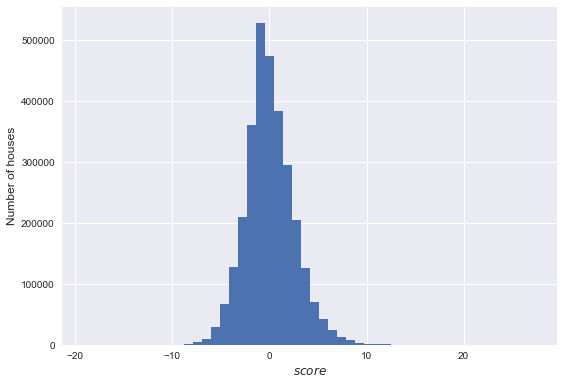

In [12]:
# Plot. Histogram of score
num_bins = 50
ax = plt.subplot()
n, bins, patches = ax.hist(scoring_result.score, num_bins)

ax.set_xlabel('$score$', fontsize=12)
ax.set_ylabel('Number of houses', fontsize=12)
#ax.set_title('Histogram of $score$', fontsize=12)

plt.tight_layout()
plt.show()

## 1.3 Discussion

The scores were ranked to figure out the most and least desirable houses. The variable *regionidcity* is also included in the scoring tables for analysis. It is used to decide whether the most desirable or least desirable houses are located in common areas.

### 1.3.1 The Most Desirable Houses: Beverly Hills

The score table and strip plot show the tendency of the most desirable houses. Among the ten most desirable houses, six houses are found to be located in the same city. The city is identified to have the variable *regionidcity* value of 12447.

**1)** Sort based on scores

In [13]:
scoring_result_ordered = scoring_result.sort_values('score', ascending=False)

**2)** Get the ten most desirable houses in the dataset

In [14]:
most_desirables = scoring_result_ordered[:10]
most_desirables = most_desirables.reset_index(drop=True)

most_desirables.index = most_desirables.index + 1
most_desirables.loc[:,['parcelid','score','regionidcity']]

,parcelid,score,regionidcity
1,11779475,27.336368,12447.000000
2,12325767,23.707704,6395.000000
3,10960072,21.260040,396054.000000
4,11641900,20.314718,12447.000000
5,11642367,20.284545,12447.000000
6,11645396,20.189754,12447.000000
7,11349969,19.936472,10734.000000
8,167638338,19.771696,34987.659995
9,11654998,19.508479,12447.000000
10,12651052,19.482287,12447.000000


The strip plot of the most desirable houses is drawn using the variable *regionidcity* and scores. Since *regionidcity* is distinct to each city and it is a categorical data, plotting as a strip plot is suitable.

In particular, the plot indicates that there are more houses with the scores between 19 and 21 regardless of *regionidcity* values. The top-ranked house is outstanding with the highest score of 27.336368.

**3)** Stripplot of the most desirable housing scores

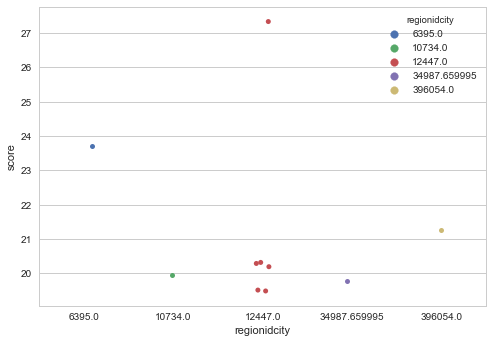

In [22]:
sns.set(style="whitegrid", color_codes=True)

ax = plt.subplot()
sns.stripplot(x="regionidcity", y="score", hue="regionidcity", data=most_desirables, jitter=True)

We found out the location of the most desirable houses with variables *longitude* and *latitude*. For the most desirable housing data, the average values of *longitude* and *latitude* were calculated to locate a city on the map. Those values indicated Beverly Hills in Los Angeles County, which is a plausible area to have a number of valuable houses.

In [23]:
# Compute the average location of most desirable houses
print('Average location of most desirable houses')
print(' Longitude : ' + str(most_desirables['longitude'].mean()/1e+6))
print(' Latitude : ' + str(most_desirables['latitude'].mean()/1e+6))

Average location of most desirable houses
 Longitude : -118.373906
 Latitude : 34.0631053


![LatLong mostdesirables](./figure/LatLong_mostdesirables.png)

### 1.3.2 The Least Desirable Houses

The same analysis was performed for the least desirable houses. However, the least desirable houses found with the scoring function **does not show a specific tendency**. They show a diffuse distribution across regions showing diverse *regionidcity* values. This is represented in the strip plot of the least desirable houses below. 

**1)** Get the ten least desirable houses in the dataset

In [24]:
least_desirables = scoring_result_ordered[-10:]
least_desirables = least_desirables.reset_index(drop=True)

least_desirables.index = least_desirables.index + 1
least_desirables.loc[:,['parcelid','score','regionidcity']]

,parcelid,score,regionidcity
1,11243663,-15.884499,13232.0
2,11651552,-16.064363,12447.0
3,12152324,-16.081543,396551.0
4,12660907,-16.139544,33612.0
5,12147406,-16.657134,50749.0
6,11490532,-16.866039,33612.0
7,12586087,-17.343808,10723.0
8,12201284,-18.629019,396053.0
9,12546681,-18.833180,46298.0
10,12186499,-19.060037,396053.0


**2)** Stripplot of the least desirable housing scores

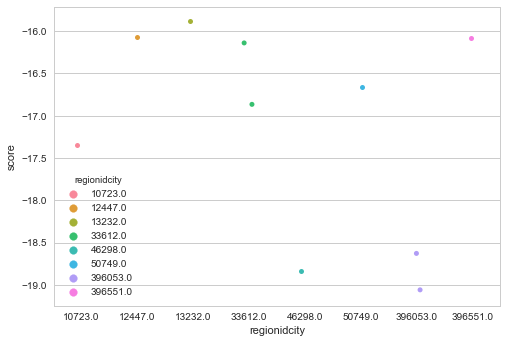

In [25]:
sns.stripplot(x="regionidcity", y="score", hue="regionidcity", data=least_desirables, jitter=True)

To compare the most desirable and the least desirable houses at a glance, we plotted locations of the 20 most desirable and 20 least desirable houses in a scatter plot. A cluster of the most desirable houses is found in Los Angeles area. On the other hand, the least desirable houses are rather spread across the region. 

**3)** Scatter plot of most and least desirable houses

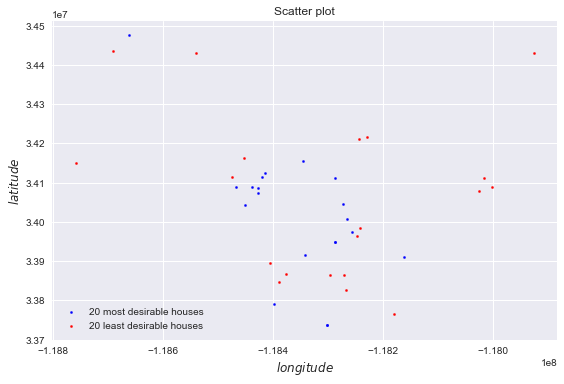

In [15]:
most_desirables_multi = scoring_result_ordered[:20]
least_desirables_multi = scoring_result_ordered[-20:]

ax = plt.subplot()
most_des = ax.scatter(most_desirables_multi.longitude, 
           most_desirables_multi.latitude, s=5, color='blue')
least_des = ax.scatter(least_desirables_multi.longitude, 
           least_desirables_multi.latitude, s=5, color='red')

ax.legend((most_des, least_des),('20 most desirable houses','20 least desirable houses'))
ax.set_xlabel('$longitude$', fontsize=12)
ax.set_ylabel('$latitude$', fontsize=12)
ax.set_title('Scatter plot', fontsize=12)

plt.tight_layout()
plt.show()

# 2 Task Two: Design Pairwise Distance Function

Many algorithms in machine learning and data mining require a *pairwise distance function (distance function)* as a basic component. This chapter shows our insights and efforts on building decent distance functions. **First** we fill elaborate on our four steps of designing a distance function. **Then** introduce a baseline distance function. **Finally** we will introduce an advanced distance function.

## 2.1 Four Aspects of a Distance Function
We break down designing a pairwise distance function into four parts:

| Aspect | Description | Memo |
|:--|:--|:--|
|1| feature selection| curse of high dimension :( |
|2| impute missing value| what is the distance between two NaN ?! |
|3| normalization| z-score ~ |
|4| what kind of distance| $L_k\ (k = ?)$|

**1) Feature Selection**

In high dimensional space, the concept of proximity, distance or nearest neighbor may not be qualitatively meaningful[[1]]. For example, in high dimensions, the performance of similarity indeing structures degrades rapidly, thus each query requires the access of almost all the data[[2]]. In english, this is known as *curse of dimensionality*[[3]]. 

`[1]`: Charu C. Aggarwal, Alexander Hinneburg, and Daniel A. Keim. "On the Surprising Behavior of Distance Metrics in High Dimensional Space".

`[2]`: Weber R., Schek H.-J., Blott S.. "A Quantitative Analysis and Performance Study for Similarity-Search Methods in High-Dimensional Spaces". VLDB Conference Proceedings, 1998.

`[3]`: Wikipedia: Curse_of_dimensionality


[1]:https://bib.dbvis.de/uploadedFiles/155.pdf
[2]:https://pdfs.semanticscholar.org/63ea/eb0c48175065ffd096aad10aed712c6d7bbb.pdf
[3]:https://en.wikipedia.org/wiki/Curse_of_dimensionality



**2) Distance Between Missing Values **

The **distance between two missing values** is an annoying part when designing a distance function. Of course, an easy way is replacing all the *NaN* with *mean*. But we do not think this is a good idea. The reason is as follows:

**mean == mean**, but **np.nan != np.nan**.

Suppose there is a feature named *bathroomcnt*. So, when replacing *NaN* with *mean*, then the distance of two *bathroomcnt = NaN* will be zero (*mean* - *mean* = 0). However, we believe the distance should not be zero. The distance should be zero, for example, when two houses both have 2 bathrooms.

After hard thinking, we finally decide to use the **random value imputation** method to replace *NaN*. It replaces *NaN* with a random value **sampled from its column (feature)**. Then the distance between two original *NaN* will be a *random value*. This will be a lot better than a *zero* distance.

Furthermore, if one is a numeric number and the other is *NaN*, then the distance will be that numeric value minus a random value sampled from its column.

In [3]:
def randomSampleImpute(df, feature_list):
    """ Replace NaN with a random value sampled from its column(feature).
    
    Args:
        df (pandas.DataFrame): data set
        feature_list   (list): a list of features, each element is a string
    """
    
    for col in feature_list:
        nan_indexes = np.argwhere(np.isnan(df[col]))             # which rows have NaN, array
        valid_series = df[col].dropna()                          # drop the NaN, Series
        random_values = valid_series.sample(n=nan_indexes.size)  # random samples, Series
        
        for nan_index, random_value in zip(nan_indexes, random_values):
            df.iat[nan_index[0], df.columns.get_loc(col)] = random_value  # replace NaN

**3) Normalization**

If we do not normalize our variables before computing distances, there will be serious biases and screw up the distance metrics. Thus, we have to first normalize the values of each dimension by Z-scores, then compute distances.

$$Z_i = (a_i-\mu )/\sigma $$

where $\mu$ is the mean of the distribution and $\sigma$ the associated standard deviation.

Also, whenever we detect a specific feature's distribution is skewed, we might need to log that feature.

In [4]:
def z_score_norm(df, feature_list):
    """ Dot the z-score method on selected features in feature_list. 
        z = (x - mean)/std
    
    Args:
        df (pandas.DataFrame): data set
        feature_list   (list): a list of features, each element is a string
    """
    
    for col in feature_list:
        df[col] = (df[col] - df[col].mean())/(df[col].std())

**4) What Kind of Distance**

*Manhatten* distance and *euclidian* distance are two commonly used distances. Actually, they are just two special cases of $L_K$ distance metric or norm, where *K=1* and *K=2* respectively.

Research results[[1]] show that Manhattan distance metric ($L_1$ norm) is consistently more preferable than the Euclidean distance metric ($L_2$ norm) for high dimensional data science applications.

[1]:https://bib.dbvis.de/uploadedFiles/155.pdf

`[1]`: Charu C. Aggarwal, Alexander Hinneburg, and Daniel A. Keim. "On the Surprising Behavior of Distance Metrics in High Dimensional Space".

## 2.2 Baseline Distance Function
A simple baseline distance function will only be based on two features: **[longiude, latitude]**. The metrics is **euclidiean**.

### 2.2.1 Design
Britain real estate tycoon Harold Samuel said: 'There are three things that matter in property: location, location, location.' Let's visualize where are the locations of the properties in the data provided by [Kaggle](https://www.kaggle.com/c/zillow-prize-1/data).

In [ ]:
def pairwise_distance_baseline(s1, s2, feature_list):
    """ Compute the distance between two series using euclidian distance. 
    
    Args:
        s1 (Series): a row in a dataframe, i.e. a property.
        s2 (Series): a row in a dataframe, i.e. a property.
    """
    X  = feature_list[0]
    Y  = feature_list[1]
    x1 = s1.at[X]
    y1 = s1.at[Y]
    x2 = s2.at[X]
    y2 = s2.at[Y]
    return euc_dis([[x1,y1]], [[x2,y2]])

In [ ]:
X = 'longitude'
Y = 'latitude'

df_ll = df_house16.loc[:,[X, Y]]
df_ll.dropna(how='any', inplace=True)
df_ll.plot.scatter(x=X, y=Y, s=1, figsize=(8,8))

After visualizing *longitude* and *latitude* and comparing them to google maps, we can find out that all the properties are in the greater Los Angeles area. Our **baseline distance function** will **only be based on locations: (longitude, latitude)**.
![la](./figure/LA_scatter.png)
![los angeles](./figure/los_angeles.png)

### 2.2.2 Example 
In this section, we will caculate the distance between two randomly selected properites. 

First clean the data.

In [8]:
# Operate the raw data and cleaned data separately.
df_house16_clean = copy.deepcopy(df_house16)

In [9]:
feature_list = ['longitude', 'latitude']
randomSampleImpute(df_house16_clean, feature_list)   # Missing value imputation
z_score_norm(df_house16_clean, feature_list)         # Normalization

Then calculate the distance between two randomly selected properties.

In [14]:
row1 = random.randint(0, 2985217)
row2 = random.randint(0, 2985217)

dis = pairwise_distance_baseline(df_house16_clean.iloc[row1], df_house16_clean.iloc[row2], feature_list)
print('The distance between #%d and #%d is %f' % (row1, row2, dis))

The distance between #693607 and #1955271 is 1.175066


In [15]:
del df_house16_clean                                 # release memory

## 2.3 Advanced Distance Function
Our advanced distance function will contain four dimensions: **['longitude', 'latitude', 'calculatedfinishedsquarefeet', 'yearbuilt']**, using **manhattan** distances.

### 2.3.1 Design

Comparing to baseline distance function with only two geographic features, we added *calculatedfinishedsquarefeet* and *yearbuilt* in the advanced distance function. This is because we believe these two are typical features for a property. 


||Dimension|
|:--|:--|
|1| longitude |
|2| latitude  |
|3| calculatedfinishedsquarefeet|
|4| yearbuilt|


In [5]:
def pairwise_distance_advance(row1, row2):
    """ Compute the distance between two properties using manhattan distance. 
    
    Args:
        s1 (1d array): a row in a matrix, i.e. a property.
        s2 (1d array): a row in a matrix, i.e. a property.
    """
        
    x1 = row1[0]  # 'longitude'
    y1 = row1[1]  # 'latitude'
    a1 = row1[2]  # 'calculatedfinishedsquarefeet'
    b1 = row1[3]  # 'yearbuilt'
    
    x2 = row2[0]
    y2 = row2[1]
    a2 = row2[2]
    b2 = row2[3]
    
    return abs(x2-x1) + abs(y2-y1) + abs(a2-a1) + abs(b2-b1)  # manhattan

### 2.3.2 Experiment

Experiment method: 

1. Do data cleaning.
2. Randomly choose a specific property $P$.
3. Compute the distance of $P$ to every property.
4. Visualize the distance distribution.

**1)** First deep copy the original raw data.

In [6]:
df_house16_clean = copy.deepcopy(df_house16)

**2)** Select four dimensions.

In [7]:
feature_list_ad = ['longitude', 'latitude', 'calculatedfinishedsquarefeet', 'yearbuilt']
df_house16_clean = df_house16_clean[feature_list_ad]

**3)** Randomly impute missing values by sampling.

In [11]:
randomSampleImpute(df_house16_clean, feature_list_ad)

**4)** Z-score the dimensions. Before z-scoring, np.log the calculatedfinishedsquarefeet since it's skrewed.

In [13]:
df_house16_clean.calculatedfinishedsquarefeet = np.log(df_house16_clean.calculatedfinishedsquarefeet)
z_score_norm(df_house16_clean, feature_list_ad)

In [20]:
df_house16_clean.head()

,longitude,latitude,calculatedfinishedsquarefeet,yearbuilt
0,-1.309366,0.587439,1.445885,-0.395162
1,-1.226195,0.570955,-0.369253,1.609709
2,-0.558016,-0.049759,8.477599,-1.632210
3,-0.681304,0.605604,2.528379,-0.693760
4,-0.532483,0.791751,0.190091,-0.736417


**5)** After data cleaning, let's calculate the distances.

In [21]:
size  = df_house16_clean.shape[0]         # size = 2985217
mat   = df_house16_clean.as_matrix()      # transform to matrix, this way is faster.
index = random.randint(0,size)            # a random index
p     = mat[index]                        # pick a random property P

array_dis = np.zeros(shape=(size,))       # an array to store the distances of $P$ to every property

for i in range(size):
    row = mat[i]
    array_dis[i] = pairwise_distance_advance(p, row)  # call the distance function

**6)** Visualize the distance distribution.

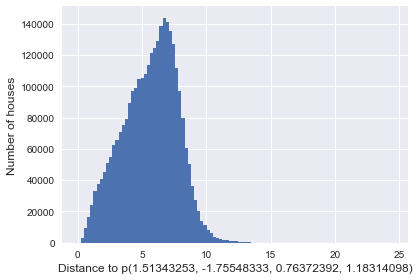

In [32]:
df_dis = pd.DataFrame(array_dis, columns=['distance'])      # from array to dataframe
df_result = pd.concat([df_house16_clean, df_dis], axis=1)   # insert the distances into df_house16_clean

# Plot. Histogram of distance
num_bins = 100
ax = plt.subplot()
n, bins, patches = ax.hist(df_result.distance, num_bins)

ax.set_xlabel('Distance to p(1.51343253, -1.75548333, 0.76372392, 1.18314098)', fontsize=12)
ax.set_ylabel('Number of houses', fontsize=12)

plt.tight_layout()
plt.show()

**7)** Show the nearest neighbors of **P** = (1.51343253, -1.75548333, 0.76372392, 1.18314098)

In [35]:
df_result[df_result.distance<0.01]

,longitude,latitude,calculatedfinishedsquarefeet,yearbuilt,distance
131290,1.515138,-1.756354,0.763724,1.183141,0.002577
250308,1.512399,-1.760110,0.763724,1.183141,0.005660
309674,1.518581,-1.756498,0.763724,1.183141,0.006164
428906,1.515489,-1.760533,0.763724,1.183141,0.007106
547797,1.513821,-1.752739,0.763724,1.183141,0.003133
577547,1.516598,-1.756856,0.763724,1.183141,0.004538
1261765,1.515500,-1.755282,0.763724,1.183141,0.002269
1410480,1.514469,-1.758232,0.763724,1.183141,0.003785
2005265,1.518564,-1.754596,0.763724,1.183141,0.006019
2124193,1.513997,-1.761227,0.763724,1.183141,0.006309


## 2.4 Discussion

First, we show our reasons why we add 2 property-specific features(*calculatedfinishedsquarefeet* and *yearbuilt*) above the simple baseline distance function, and formed a four dimensional distance function. The caculated finished square feet area is probably the most important attribute a person cares except the location. In similar locations, a larger house is mostly more valuable than a smaller house and a better place to live in. Year built is also a critical attribute for a house. Year built is correlated to many interesting features of a property. For example, people lived in different decades may prefer different architectual styles. In the 1950s, many people prefered raised ranch style houses and many that kind houses are build at that time period.

Second, we tell why we decided to use the *mahanttan* distance. According to section 2.1.4, Manhattan distance metric ($L_1$ norm) is consistently more preferable than the Euclidean distance metric ($L_2$ norm) for high dimensional(n>3) data science applications.

Third, we explain how we come up with our experiment method. We have nearly 3 million rows in a dataframe. It is quite impractical to compute the distances of every pair of rows, since doing so will need a 3 million $\times$ 3 million matrix to store the results. So instead, we randomly pick a specific property **P**, then compute the distances of **P** to every properties.

Fourth, we looked at the results of our advanced distance function, it looks pretty well. Below are the evaluation. We visualized the distance distribution. According to the figure, **distance = 7** is a threshold. When **distance < 7**, the Y value of the histogram grows almost linearly. The peak Y value is just above 140,000. Which means that there are 140,000 properties whose distance wich **P** is 7. When **distance > 7 **, the Y value first decreases rapidly almost linearly, then the decrease rate gets slower and slower. We printed some near neighbors of **P** who has a distance less than 0.01. No surprisingly, the nearest neighbors have a very close value on all four dimensions. **We picked the ($L_1$ norm) distance metrics  to reward properties for being close on all four dimensions**.

Fifth, we tried to interpret the meanings of our high dimension distance function. However, we figured out we can **hardly tell the geometric sense** of it. The only thing we are sure is that, according to our distance function, these properties are close to each other or far from each other.

To sum up, a simple distance function and a carefully designed advanced distance function all work well as we expected. 

# 3 Task 3: Clustering
In this chapter, we will cluster the properties with two different clusting algorithms: KMeans and DBSCAN. 

|Cluster Algorithm|Distance Function|Dimensions|Metrics|
|:-- | :-- | :-- | :-- |
| KMeans | pairwise_distance_baseline| longitude, latitude | Euclidian|
| DBSCAN | pairwise_distance_advance| longitude, latitude, calculatedfinishedsquarefeet, yearbuilt| Manhanttan |


## 3.1 KMeans + Euclidean (pairwise_distance_baseline)

**1)** Select two features (dimension)

In [13]:
feature_list = ['longitude', 'latitude']
df_ll = df_house16[feature_list]

**2)** Data cleaning 

In [ ]:
randomSampleImpute(df_ll, feature_list)
z_score_norm(df_ll, feature_list)

**3)** Run k-means with 15 clusters.

In [17]:
kmeans = KMeans(init='k-means++', n_clusters=15)
kmeans.fit(df_ll)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=15, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

**4)** Visualize the clustering results

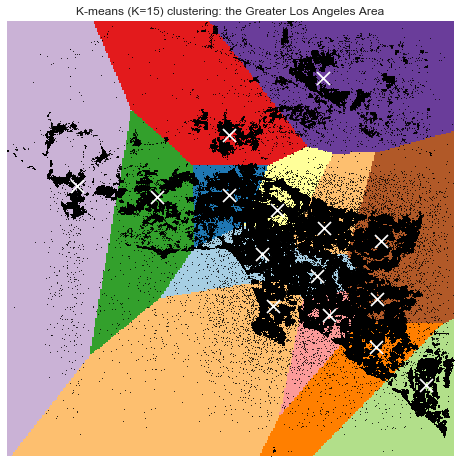

In [18]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = df_ll.iloc[:, 0].min(), df_ll.iloc[:, 0].max()
y_min, y_max = df_ll.iloc[:, 1].min(), df_ll.iloc[:, 1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(8,8))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(df_ll.iloc[:, 0], df_ll.iloc[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means (K=15) clustering: the Greater Los Angeles Area')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

## 3.2 DBSCAN + Manhanttan (pairwise_distance_advance)

### 3.2.1 Data Cleaning

**1)** Deep copy the original raw data.

In [30]:
df_house16_clean = copy.deepcopy(df_house16)

**2)** Choose a subset of the total data. We will do this by merging with the 2016 training data on *parcelid*. That will give us 90275 rows of data. So, from a large 3-million-row data down to a delicate 90-thousand-row of data.

In [31]:
df_house16_clean = pd.merge(df_train16, df_house16_clean, on='parcelid')

**3)** Select four dimensions: *longitude*, *latitude*, *calculatedfinishedsquarefeet*, *yearbuilt*.

In [32]:
feature_list_ad = ['longitude', 'latitude', 'calculatedfinishedsquarefeet', 'yearbuilt']
df_house16_clean = df_house16_clean[feature_list_ad]

**4)** Randomly impute missing values by sampling

In [33]:
randomSampleImpute(df_house16_clean, feature_list_ad)

**5)** Z-score the dimensions. Before z-scoring, np.log the calculatedfinishedsquarefeet since it's skrewed.

In [34]:
df_house16_clean.calculatedfinishedsquarefeet = np.log(df_house16_clean.calculatedfinishedsquarefeet)
z_score_norm(df_house16_clean, feature_list_ad)

**6)** Visualize the subset of 90275 rows of data. The data have four features (dimensions), but we visualize the two-dimensional projections of the data: *longitude* and *latitude*.

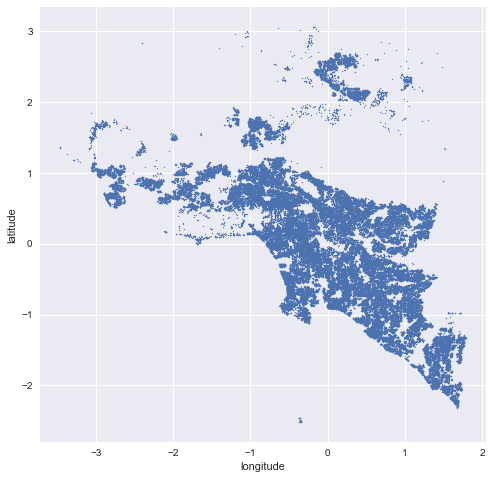

In [35]:
df_ll = copy.deepcopy(df_house16_clean)
df_ll = df_ll[['longitude', 'latitude']]
df_ll.plot.scatter(x='longitude', y='latitude', s=1, figsize=(8,8))

### 3.2.2 Do the Clustering and Visualization
We use our pairwise_distance_advance not by passing the function into sklearn.cluster.DBSCAN's parameter, but by **preprosessing the data** and passing **metric='manhattan'** into sklearn.cluster.DBSCAN's parameter. They are equivalent.

In [38]:
# Compute DBSCAN
X = df_house16_clean

db = DBSCAN(eps=0.3, metric='manhattan', min_samples=40).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 85


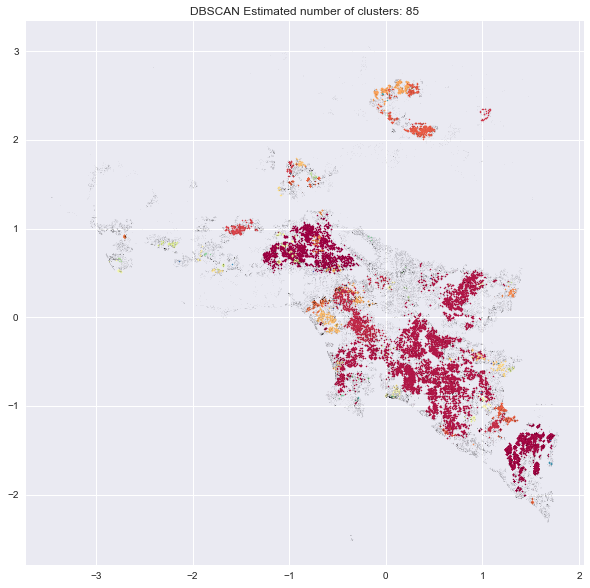

In [39]:
# Plot result
# Black removed and is used for noise instead.
X = X.as_matrix()

plt.figure(figsize=(10,10))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=1.5)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=0.15)

plt.title('DBSCAN Estimated number of clusters: %d' % n_clusters_)

![la-kmean](./figure/kmeans-85.png)
Above is the visualization of kmeans clustering with *k=85*. Comparing to dbscan, the visualization result looks better.

## 3.3 Discussion

K-means clustering is fast, simple, and generally effective. It works by minimizing the within-cluster sum of squares:
$$argmin \sum_{i=1}^{k} \sum_{x\in S_i}\left \| x - \mu_i \right \|^2$$
where $u_i$ is the mean of points in $S_i$, $k$ is the number of cluster[[1]](https://en.wikipedia.org/wiki/K-means_clustering). K-means needs to specify the number $k$ during initialization.

DBSCAN: **D**ensity-**B**ased **S**patial **C**lustering of **A**pplications with **N**oise. Finds core samples of high density and expands clusters from them. Good for data which contains clusters of similar density [[2]](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html). DBSCAN don't need to specify the number of clusters during initialization. Instead, we need to initialize $eps$ and $min\_samples$. The former is the maximum distance between two samples for them to be considered as in the same neighborhood, and the latter is the number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself. I tested the limits of DBSCAN, and found out that DBSCAN will eat up all my PC's RAM (then my PC crashes) when we run on all nearly 3 million rows of data. **Consequently, we have to choose a subset of the total data**.

We first cluster the properties using kmeans with *k=15* and *pairwise_distance_baseline*. The cleaned data is 2985217 rows. The figure looks beautiful at a first glance and we were delighted for our job well done. The only thing that seemed a little strange is that there are some properties "in the ocean". We quickly realized that this is because the longitute and latitude of properties are normalized, so that they distribute across the whole figure. The clustering result seems very straight forward and the figure is very self-descriptive.

Then we cluster the properties using DBSCAN with *eps=0.3*, *min_samples=30*, and *pairwise_distance_advance*. The cleaned data is only 90275 rows. When there are too many rows, the DBSCAN will eat up all the RAM. The algorithm come out with *85* clusters. Our DBSCAN's visualization result is not as good looking as kmeans's. The clustering result has too many noise in it. While visualizing, we ploted the noise as very tiny black dots. These dots do not belong to any clusters. 

Last, we cluster agian using kmeans. This time with *k=85*, and the same number as the result of DBSCAN. The cleaned data is only 90275 rows. The visualizing figure is quite interesting. The figure is very colorful with many clusters. The graph again looks pretty beautiful.

The kmeans clustering result is purly based on two geographical dimensions, and the visualization is based on the same two geographical dimensions. DBSCAN not only has two geographical dimensions, but also has two property-specific dimensions. However, when visualizing, we are only able to visualize on the two geographical dimensions, neglecting the two property-specific dimensions. We consider this as the reason why the figures of DBSCAN is not as good looking as kmeans', since we can only visualize half of DBSCAN's dimension, missing the other half of the dimensions which contain important.


`[1]`: wikipedia.org: K-means_clustering

`[2]`: scikit-learn.org

# 4 Task 4: Adding External Data Set

## 4.1 Select External Data: Treasury Rates

Initially, we considered to add some geographical data, such as crime rate. To add a new crime rate column into the original properties table, we need to merge the crime rate data on a common key, for example, regionidzip. So that the each property could match the correct crime rate. However, we found that **regionidzip** in the original properties table was **not the real zip code**, i.e. they are masked. We don't know how the they change the real zip code into a masked zip code. Thus we can not directly add the crime rate data. Although there are some complicated methods to solve this problems, we **dicided to workaround**.

Our alternate plan is to use **financial data** and merge financial data with the original properties data set on common key **year**. The year is correct, so we can correctly insert the financial data into the right places. 

First, we want to use **federal interest rates** from 1800 to 2017, but we only obatin data from 1954 to 2017. So it is not suffient for our data analysis. 

Then we find that **treasury rates** are available. Since when interest rates go higher, people will turn to government bond, which makes the price of government bond go lower, then the treasury rates become higher. Hence the interest rates are correlated with treasury rates. The real estate market is strongly affected by the financial market. So financial features such as treasury rates will be a good influence factor to properties. So we believe treasury rates will be a good feature that is correlated to properties and can improve the prediction accuracy on properties.

### 4.1.1 Import the Data

We can get treasury rates from 1871 to 2017 using data from this website.
[[1]](http://www.multpl.com/10-year-treasury-rate/table/by-year)

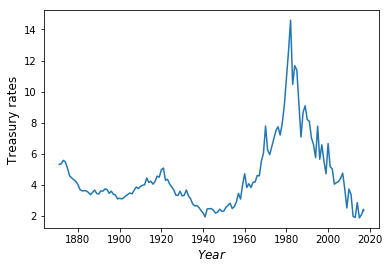

In [5]:
treasuryrates = pd.read_csv('../data/treasury rates1.csv')
treasuryrates.columns = ['treasuryrates','yearbuilt']
treasuryrates['yearbuilt']=treasuryrates['yearbuilt'].astype(int)

plt.xlabel('$Year$', fontsize=12)
plt.ylabel('Treasury rates', fontsize=12)
plt.plot(treasuryrates['yearbuilt'],treasuryrates['treasuryrates'])

In [6]:
treasuryrates.head()

,treasuryrates,yearbuilt
0,2.35,2017
1,2.43,2017
2,2.09,2016
3,1.88,2015
4,2.86,2014


### 4.1.2 Choose Features

There are properties from 2016 and 2017. We can use these two datasets separately to predict the logerror.

In [ ]:
house_df = pd.read_csv('../data/properties_2016.csv')

As for chossing properties in data, we choose these four features because they are correlated to logerror. Their correlations are higher than other features.

| Feature | Name  | 
|:--|:--|
|1| bedroomcnt| 
|2| calculatedfinishedsquarefeet| 
|3| yearbuilt | 
|4| structuretaxvaluedollarcnt | 

In [10]:
feature=['parcelid','bedroomcnt','calculatedfinishedsquarefeet','yearbuilt',
         'structuretaxvaluedollarcnt']
feature1=['bedroomcnt','calculatedfinishedsquarefeet','yearbuilt','structuretaxvaluedollarcnt']
house_new_df1=house_df[feature]

After that we can merge these features with the treasury rates.

In [14]:
house_new_df=treasuryrates.merge(house_new_df1, how='left', on='yearbuilt')

There are some lines which missing so many features, so we delete these lines to make the data cleaner.

In [18]:
house_new_df.drop(house_new_df.index[[0,1,2,2925248,2925249,2925250]],inplace=True)

Then fill the blank NaN with mean.

In [19]:
house_new_df=house_new_df.fillna(house_new_df.mean())
house_new_df['parcelid']=house_new_df['parcelid'].astype(int)

Get the train data from datasets.

In [23]:
train_df = pd.read_csv('../data/train_2016_v2.csv')
join_df = train_df.merge(house_new_df, how='left', on='parcelid')

In [ ]:
train_df = pd.read_csv('../data/train_2017.csv')
join_df = train_df.merge(house_new_df, how='left', on='parcelid')

In [25]:
target = join_df.loc[:,'logerror']
feature = join_df.iloc[:,2:]

Use feature to represent the train model, and target to represent the logerror.

Do the type transform for transactiondate. Cause the transactiondate is object and we need float to do the predictions, so we need datetime to transform them.

In [27]:
for num,str in enumerate(feature.transactiondate):
    date_time = datetime.datetime.strptime(str,'%Y-%m-%d')
    st = time.mktime(date_time.timetuple())
    feature.set_value(num,'transactiondate',st)

In [28]:
feature['transactiondate'] = feature['transactiondate'].astype(float)

Also define the date_transform for test data.

In [30]:
def date_transform(df_test):
    for num,str in enumerate(df_test.transactiondate):
        date_time = datetime.datetime.strptime(str,'%Y-%m-%d')
        str = time.mktime(date_time.timetuple())
        df_test.set_value(num,'transactiondate',str)
    df_test['transactiondate'] = df_test['transactiondate'].astype(float) 
    test_matrix = df_test.as_matrix()
    return test_matrix

In [31]:
feature['yearbuilt']=feature['yearbuilt'].astype(float)

Import the sample data.

In [33]:
sample = pd.read_csv("../data/sample_submission.csv")
sample1 = sample.ParcelId
sample1 = sample1.to_frame()
sample1.columns = ['parcelid']
df_test = sample1.merge(house_new_df, on='parcelid', how='left')
df_test['yearbuilt']=df_test['yearbuilt'].astype(float)

fill the test data and feature data with mean.

In [39]:
df_test=df_test.fillna(df_test.mean())
feature=feature.fillna(feature.mean())
#df_test
del df_test['parcelid']

use z_score to normalize the data sets.

In [42]:
z_score_norm(feature,feature1)
z_score_norm(df_test,feature1)

## 4.2 Prediction

After we do the data processing, we use linear regression to build our model. Linear regression is one of the basic and useful methods to obtain good datasets. 

In [44]:
model = linear_model.LinearRegression()
model = model.fit(feature, target)

In [51]:
result = sample1.copy()
result.columns = ['ParcelId']
test1 = df_test.copy()
test1.insert(0,'transactiondate','2016-10-15')
test1 = date_transform(test1)
pred1 = model.predict(test1)
pred1 = np.asarray(pred1)
result.insert(1,'201610',pred1)

test2 = df_test.copy()
test2.insert(0,'transactiondate','2016-11-15')
test2 = date_transform(test2)
pred2 = model.predict(test2)
pred2 = np.asarray(pred2)
result.insert(2,'201611',pred2)


test3 = df_test.copy()
test3.insert(0,'transactiondate','2016-12-15')
test3 = date_transform(test3)
pred3 = model.predict(test3)
pred3 = np.asarray(pred3)
result.insert(3,'201612',pred3)


test4 = df_test.copy()
test4.insert(0,'transactiondate','2017-10-15')
test4 = date_transform(test4)
pred4 = model.predict(test4)
pred4 = np.asarray(pred4)
result.insert(4,'201710',pred4)


test5 = df_test.copy()
test5.insert(0,'transactiondate','2017-11-15')
test5 = date_transform(test5)
pred5 = model.predict(test5)
pred5 = np.asarray(pred5)
result.insert(5,'201711',pred5)


test6 = df_test.copy()
test6.insert(0,'transactiondate','2017-12-15')
test6 = date_transform(test6)
pred6 = model.predict(test6)
pred6 = np.asarray(pred6)
result.insert(6,'201712',pred6)

In [52]:
result.columns = ['ParcelId', '201610', '201611', '201612', '201710','201711','201712']
# change filename per run
result.to_csv('../sample 1013 first attempt.csv',index=False,header=True) 

## 4.3 Discussion

We have submit the predictions on Kaggle. Using linear regression without treasury rates gets a score of 0.0650050, while using linear regression with treasury rates gets a score of 0.0649963. 

![fig 1](figure/submission-0.649963.jpg)


![fig 2](figure/submission-0.650050.png)


From these scores, we can see that treasury rates provide a increase on prediction. So we can see that treasury rates can influence the logerror to a certain extent. 

At first, we see that there are some properties about geographical information, which includes longtitude, latitude, regionid and so on. But the only useful information is latitude and longitude. The regionid, regioncity and regionzip are masked, from which we can't know houses' geographical information. The only two properties we can use is latitude and longitude, while we don't find enough criminal rates matching these two properties. So after some consideration, we decide not to use the geographical information and turn to some finacial properties related to yearbuilt.

Treasury rates, that is treasury yields which is the return on investment, expressed as a percentage, on the U.S. government's debt obligations (bonds, notes and bills). Looked at another way, the Treasury yield is the interest rate the U.S. government pays to borrow money for different lengths of time.
[[2]](http://www.investopedia.com/terms/t/treasury-yield.asp)

So we can see that the financial situation is related to the people's daily life, which influence the price and logerror. Adding the treasury rates as external data is useful for our predictions.

# 5 Task 5: Prediction Model

## 5.1 Modified Prediction Model

First, we have found that integrating the treasury rates as external data is helpful for the prediction model. Thus the feature is included for building the modified prediction model. 

In addition, we tried to apply the new housing dataset for the year 2017, which was recently provided in Kaggle competition.

**1)** Read data

In [18]:
# Read the property data
house_df16 = df_house16
house_df17 = df_house17

# Read the training data
train_df16 = df_train16
train_df17 = df_train17

In [19]:
# Read treasury rate data
treasuryrates = pd.read_csv('../data/treasury_rates.csv')

treasuryrates.columns = ['treasuryrates','yearbuilt']
treasuryrates['yearbuilt'] = treasuryrates['yearbuilt'].astype(int)

**2)** Extract features for the prediction model

In [20]:
feature_list = ['parcelid','bedroomcnt','buildingqualitytypeid',
                'calculatedbathnbr','calculatedfinishedsquarefeet',
                'lotsizesquarefeet','yearbuilt']

feature_data16 = house_df16[feature_list]
feature_data17 = house_df17[feature_list]

**3)** Merge the housing feature datasets with the treasury rate dataset

In [21]:
feature_data16 = pd.merge(feature_data16, treasuryrates, on='yearbuilt')
feature_data17 = pd.merge(feature_data17, treasuryrates, on='yearbuilt')

**4)** Fill in the holes in the datasets

In [22]:
model_dataset16 = feature_data16
model_dataset17 = feature_data17

model_dataset16 = model_dataset16.fillna(model_dataset16.mean())
model_dataset17 = model_dataset17.fillna(model_dataset17.mean())

**5)** Merge feature dataset with the training dataset

In [23]:
model_dataset16 = pd.merge(model_dataset16, train_df16, on='parcelid')
model_dataset17 = pd.merge(model_dataset17, train_df17, on='parcelid')

**6)** Concatenate 2016 and 2017 datasets

In [24]:
model_dataset = pd.concat([model_dataset16, model_dataset17])

**7)** Preprocessing for the prediction model. Normalize the features with skewed distributions.

In [25]:
model_dataset_norm = model_dataset

model_dataset_norm.calculatedbathnbr = np.log(model_dataset_norm.calculatedbathnbr)
model_dataset_norm.calculatedfinishedsquarefeet = np.log(model_dataset_norm.calculatedfinishedsquarefeet)
model_dataset_norm.lotsizesquarefeet = np.log(model_dataset_norm.lotsizesquarefeet)

In [26]:
all_inputs = model_dataset_norm.loc[:,'bedroomcnt':'treasuryrates']
all_outputs = model_dataset_norm.loc[:,'logerror']

In [28]:
all_inputs.loc[:,'bedroomcnt':'treasuryrates'] = preprocessing.scale(all_inputs.loc[:,'bedroomcnt':'treasuryrates'])

**8)** Cross validation

In [ ]:
(training_inputs, test_inputs, 
 training_outputs, test_outputs) = train_test_split(all_inputs, all_outputs, train_size=0.75, random_state=1)

## 5.2 Do the Prediction

In [30]:
regr = linear_model.LinearRegression()

# Train the model using the training dataset
regr.fit(training_inputs, training_outputs)

# Make predictions using the test dataset
test_pred = regr.predict(test_inputs)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(test_outputs, test_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.5f'
      % r2_score(test_outputs, test_pred))

Coefficients: 
 [ 0.00327352 -0.00130588 -0.00157029  0.00459262  0.00221111  0.00115801
 -0.00053935]
Mean squared error: 0.03
Variance score: 0.00028


In [31]:
sample_submission = pd.read_csv('../data/sample_submission.csv', na_values=['NA'])

In [32]:
property_data = df_house17

feature_list = ['parcelid','bedroomcnt','buildingqualitytypeid',
                'calculatedbathnbr','calculatedfinishedsquarefeet',
                'lotsizesquarefeet','yearbuilt']

test_data = property_data[feature_list]

In [33]:
test_data = pd.merge(test_data, treasuryrates, how='left', on='yearbuilt')

In [34]:
test_data_filled = test_data.fillna(test_data.mean())

In [35]:
test_data_norm = test_data_filled

# Normalize the features with skewed distributions
test_data_norm.calculatedbathnbr = np.log(test_data_norm.calculatedbathnbr)
test_data_norm.calculatedfinishedsquarefeet = np.log(test_data_norm.calculatedfinishedsquarefeet)
test_data_norm.lotsizesquarefeet = np.log(test_data_norm.lotsizesquarefeet)

test_data_norm.loc[:,'bedroomcnt':'treasuryrates'] = preprocessing.scale(test_data_norm.loc[:,'bedroomcnt':'treasuryrates'])
test_inputs = test_data_norm.loc[:,'bedroomcnt':'treasuryrates']

In [36]:
# Make predictions using the test dataset
test_prediction = regr.predict(test_inputs)

In [37]:
submission = sample_submission
submission.iloc[0:,1] = test_prediction
submission.iloc[0:,2] = test_prediction
submission.iloc[0:,3] = test_prediction
submission.iloc[0:,4] = test_prediction
submission.iloc[0:,5] = test_prediction
submission.iloc[0:,6] = test_prediction

In [38]:
submission.to_csv('../data/submission_1015_treasury_norm.csv', sep=',', index=False)

## 5.3 Discussion

To build a modified prediction model, the housing datasets of 2016 and 2017 are combined into a single dataset to obtain a larger training dataset. The housing features and log error datasets were combined respectively depending on the year that a house is sold. As a result, the size of training dataset had been doubled. However, we found out that there are multiple records of a house that has been sold more than one time. We dealt each of the sold records as a respective training data point.

We use more variables compared to the model in Task 4. The additional variables are the ones that found to be relevant to the desirability of a house in Task 1. The treasury rate variable is integrated into the provided housing dataset to improve the prediction model. Therefore, the following variables are used for the prediction model:

|  | Variable |
|:--|:--|
|1| *bedroomcnt* |
|2| *buildingqualitytypeid* |
|3| *calculatedbathnbr* |
|4| *calculatedfinishedsquarefeet* |
|5| *lotsizesquarefeet* |
|6| *yearbuilt* |
|7| *treasuryrate* |

Using the variables, a linear regression model had been built as a modified prediction model. Although the number of variables and the size of training dataset increased compared to Task 4, the prediction model got a score of 0.0655610. This shows that the simpler model in Task 4 performed better than the newly modified model.

![task5_model_result](./figure/submission-0.0655610.png)

It might be necessary to analyze the correlation between the additional housing variables for this task and the treasury rate variable to improve this prediction model further. Rather than a linear regression model, we may need to implement a prediction model that can reflect the complex relationship between increase number of variables.

# 6 Task 6: Permutation Test

As for permutation test, we do around 120 tests to predict the logerror. 

**First**, we generate new train sets and tests sets. Divide the original train sets into 10 groups, and the first nine groups are train sets and the last one is test sets. 

**Then** we do the prediction with new train sets and test sets. 

**Finally**, we use the new prediction results and the logerror in test sets to calculate the Mean absolute error as a metric. We do about 120 tests and obtain 120 mae value and then calculate the p value.

## 6.1 Preparation for test

1) First, we use some data in train set to do the test. We divide the train sets into 10 parts. The first nine copies are new train sets, while the last one copy is the new test set.

In [6]:
train_df = pd.read_csv('../data/train_2016_v2.csv')
test_id=range(0,90275,10)
test=train_df.loc[test_id]
train_new_df=train_df[train_df.index%10!=0]

2) Then we merge the new train set with the properties sets.

In [7]:
house_df = pd.read_csv('../data/properties_2016.csv')
join_df = train_new_df.merge(house_df, how='left', on='parcelid')

3) Choose some features to do the prediction.

In [8]:
feature2=['parcelid','transactiondate','bedroomcnt','calculatedfinishedsquarefeet','yearbuilt',
         'structuretaxvaluedollarcnt','logerror']
join_df1=join_df[feature2]

In [9]:
target = join_df1.loc[:,'logerror']
feature = join_df1.iloc[:,1:6]

In [10]:
for num,str in enumerate(feature.transactiondate):
    date_time = datetime.datetime.strptime(str,'%Y-%m-%d')
    st = time.mktime(date_time.timetuple())
    feature.set_value(num,'transactiondate',st)
feature['transactiondate'] = feature['transactiondate'].astype(float)

In [11]:
def date_transform(df_test):
    for num,str in enumerate(df_test.transactiondate):
        date_time = datetime.datetime.strptime(str,'%Y-%m-%d')
        str = time.mktime(date_time.timetuple())
        df_test.set_value(num,'transactiondate',str)
    df_test['transactiondate'] = df_test['transactiondate'].astype(float) 
    test_matrix = df_test.as_matrix()
    return test_matrix

4) Use the new test set to do the prediction.

In [12]:
sample = test
sample1=sample
df_test1=sample1.merge(house_df, on='parcelid', how='left')

In [13]:
feature3=['parcelid','bedroomcnt','calculatedfinishedsquarefeet','yearbuilt',
         'structuretaxvaluedollarcnt']
df_test=df_test1[feature3]

df_test=df_test.fillna(df_test.mean())
feature=feature.fillna(feature.mean())
#df_test
del df_test['parcelid']

5) Do the normalization for train set and test set.

In [15]:
feature1=['bedroomcnt','calculatedfinishedsquarefeet','yearbuilt','structuretaxvaluedollarcnt']
z_score_norm(feature,feature1)
z_score_norm(df_test,feature1)

6) Use the new train set and test set to get new linear regression model.

In [16]:
model = linear_model.LinearRegression()
model = model.fit(feature, target)

In [17]:
test1 = df_test.copy()
test1.insert(0,'transactiondate','2016-10-15')
test1 = date_transform(test1)
pred1 = model.predict(test1)
pred1 = np.asarray(pred1)

7) Use mean absolute error to calculate the score of our model.

In [19]:
mae_origin=mean_absolute_error(test['logerror'],pred1)

In [20]:
mae_origin

0.065175186682973119

## 6.2 120 Tests

After getting the original mae value, we can shuffle our logerror and do the permutation tests. It is reasonable to do about 120 tests. Because 1000 tests take more time. So first we want to new a mae_list to store the mae results of these permutation tests.

In [23]:
mae_list=[0.06517518668297312]

Then we use count to represent the time of code running. Every time we do a new shuffle and a new test, we let count increase one. After repeating 120 times, we have done 120 permutation tests.

In [ ]:
count=0
while count<120:
    count=count+1 
    print count
    #train_df = pd.read_csv('../data/train_2016_v2.csv')
    test_id=range(0,90275,10)
    test=train_df.loc[test_id]

    train_new_df1=train_df[train_df.index%10!=0]

    list1=train_new_df1['logerror'].tolist()
    random.shuffle(list1)
    train_new_df=train_new_df1.drop('logerror',axis=1, inplace=False)
    train_new_df.insert(1,'logerror',list1)

    #house_df = pd.read_csv('../data/properties_2016.csv')
    join_df = train_new_df.merge(house_df, how='left', on='parcelid')

    feature2=['parcelid','transactiondate','bedroomcnt','calculatedfinishedsquarefeet','yearbuilt',
         'structuretaxvaluedollarcnt','logerror']
    join_df1=join_df[feature2]

    target = join_df1.loc[:,'logerror']
    feature = join_df1.iloc[:,1:6]
    
    for num,str in enumerate(feature.transactiondate):
        date_time = datetime.datetime.strptime(str,'%Y-%m-%d')
        st = time.mktime(date_time.timetuple())
        feature.set_value(num,'transactiondate',st)
    feature['transactiondate'] = feature['transactiondate'].astype(float)

    sample = test
    sample1=sample
    df_test1=sample1.merge(house_df, on='parcelid', how='left')

    feature3=['parcelid','bedroomcnt','calculatedfinishedsquarefeet','yearbuilt',
         'structuretaxvaluedollarcnt']
    df_test=df_test1[feature3]

    df_test=df_test.fillna(df_test.mean())
    feature=feature.fillna(feature.mean())
    #df_test
    del df_test['parcelid']

    z_score_norm(feature,feature1)
    z_score_norm(df_test,feature1)

    model = linear_model.LinearRegression()
    model = model.fit(feature, target)

    test1 = df_test.copy()
    test1.insert(0,'transactiondate','2016-10-15')
    test1 = date_transform(test1)
    pred1 = model.predict(test1)
    pred1 = np.asarray(pred1)

    #from sklearn.metrics import mean_absolute_error
    mae_shuffle=mean_absolute_error(test['logerror'],pred1)
    mae_list.append(mae_shuffle)

After we do the permutation tests, we want to see the distribution of our results. For mae results, we use a bar chart to represent their distribution.

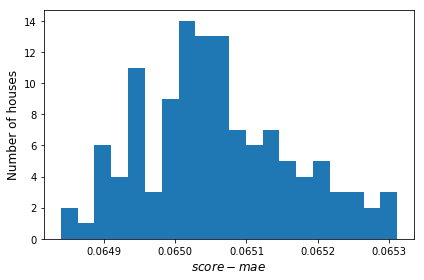

In [26]:
num_bins = 20
ax = plt.subplot()
n, bins, patches = ax.hist(mae_list, num_bins)

ax.set_xlabel('$score-mae$', fontsize=12)
ax.set_ylabel('Number of houses', fontsize=12)
#ax.set_title('Histogram of $score$', fontsize=12)
#sns.distplot(mae_list,label='mae distribution')
plt.tight_layout()
plt.show()

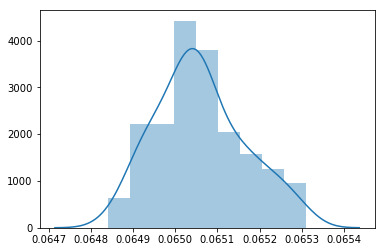

In [27]:
sns.distplot(mae_list,label='mae distribution')

The p_value = 0.85 looks not very good.

In [40]:
mae_df=pd.DataFrame({'mae':mae_list})
compare=mae_df[mae_df.mae<0.065175186683]
p=float(len(compare))
p_value=p/121
print p
print p_value

103.0
0.851239669421


## 6.3 Discussion

A permutation test (also called a randomization test, re-randomization test, or an exact test) is a type of statistical significance test in which the distribution of the test statistic under the null hypothesis is obtained by calculating all possible values of the test statistic under rearrangements of the labels on the observed data points. 
[[1]](https://en.wikipedia.org/wiki/Resampling_(statistics)

So we use permutation tests to see our model results. We do about 120 tests to see the differences between our predictions and real logerrors. Then use the mean absolute error to score our results.

Mean absolute error (MAE) is a measure of difference between two continuous variables. Assume X and Y are variables of paired observations that express the same phenomenon. Examples of Y versus X include comparisons of predicted versus observed, subsequent time versus initial time, and one technique of measurement versus an alternative technique of measurement. 
[[2]](https://en.wikipedia.org/wiki/Mean_absolute_error)

So it is a useful tool for prediction. Then we calculate the p value of results. The p-value or probability value is the probability for a given statistical model that, when the null hypothesis is true, the statistical summary (such as the sample mean difference between two compared groups) would be the same as or of greater magnitude than the actual observed results.
[[3]](https://en.wikipedia.org/wiki/P-value)

So as we can see, we use mean absolute error to score our predcition. And the p_value is **p_value is 0.851239669421**, which is a bit larger than we think, and linear regression is not a very good model for prediciting this particular Zillow task.

# 7 Task 7: Submit Final Result before Deadline

The following are our two final submissions:

![sumbit-0.0649](./figure/submission-0.649963-2.jpg)
![sumbit-0.0649](./figure/submission-0.650050-2.png)

In total our group spend **thousands of hours** doing **data analysing, cleaning** and trained **four** different models in total: **linear regression, ridge regression, random forest regreesion**, and the **multi-layer perceptron regressor**. Since we are relatively new to these models, we can not handle these model well enough. Our finial submission result is pretty much mediocre. Nevertheless, we learned tremendous amount of new stuffs during the progress. 

More importantly, we truely understood **solidarity means strength**. By working together as a team, we are able to come out with better ideas and generate better results. In homework 3, every team member did two tasks. We combined our work thourgh Git/GitHub. During this busy mid-term period, we would never finish all the six tasks if we were doing along, since the workload is overwhelming. 

In the end, I truely appreciate our teammates for all what they devoted. After this homework, we deeply believe we already have a solid foundation for the coming course project.